# Prostate Cancer Worshop

## Initial analysis

### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from feature_engine.outliers import Winsorizer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from bayes_opt import BayesianOptimization
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from xgboost import XGBClassifier


### LoadingData

In [2]:
df_train = pq.read_table('data/df_train.parquet').to_pandas()
df_test = pq.read_table('data/df_test.parquet').to_pandas()

df_train.shape

(23494, 46)

In [3]:
df_train.head()

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
16484,12.0,3.0,3.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,58373.057143,-110021.200000,1.885690e+05
11528,6.0,1.0,1.0,2,0.5,NaN,0.0,NaN,NaN,1.0,...,0,0,0,0,0,0,0,19618.942857,-36176.133333,9.747050e+04
26630,1.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,1,398534.000000,-626628.000000,2.304723e+06
12586,6.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,1292.600000,13410.733333,5.380450e+04
11225,3.0,0.0,2.0,1,1.0,NaN,0.0,NaN,NaN,1.0,...,2,2,2,2,2,2,0,13728.714286,-27375.666667,4.134967e+04


In [4]:
numeric_columns = [
    'Cant_gr_flia', 
    'Cant_riesgos_flia_mean', 
    'cantidad_serv_flia', 
    'CANTIDAD_SERVICIOS', 
    'conteo_dx_diferentes', 
    'EDAD', 
    'psa_max_gr_flia', 
    'psa_min_gr_flia', 
    'Pendiente', 
    'Pendiente_flia', 
    'Promedio_costo', 
    'Promedio_costo_flia', 
    'psa_max_gr_flia', 
    'psa_min_gr_flia', 
    'MEDICAMENTOS', 
    'MEDICINA ESPECIALIZADA', 
    'MEDICINA GENERAL', 
    'TIEMPO_AFILIACION', 
    'TIEMPO_ULTIMA_CITA', 
    'PERDIDA_DE_PESO', 
    'Intercepto', 
    'Intercepto_flia', 
    'Target',
    'Cant_Fliar_CP', 
    'Cant_Fliar_riesgos'
]

categorical_columns = [
    'AGRUPACION_DIASTOLICA', 
    'AGRUPACION_SISTOLICA', 
    'CANCER_MAMA_FAMILIAR', 
    'CANCER_OTRO_SITIO', 
    'CORONARIOS', 
    'CANCER_OTRO_SITIO_FAMILIAR',
    'CORONARIOS_FAMILIAR', 
    'CEREBRAL', 
    'CEREBRAL_FAMILIAR', 
    'DIABETES', 
    'DIABETES_FAMILIAR', 
    'ENFERMEDAD_RENAL', 
    'ENFERMEDAD_RENAL_FAMILIAR', 
    'HIPERTENSION', 
    'HIPERTENSION_FAMILIAR', 
    'OTROS_ANTECEDENTES_VASCULARES', 
    'RIESGOS', 
    'ESTADO_CIVI', 
    'estrato', 
    'parentesco', 
    'PROGRAMA', 
]

In [5]:
ordinal_columns = [
    'AGRUPACION_DIASTOLICA',
    'AGRUPACION_SISTOLICA',
    'HIPERTENSION',
    'HIPERTENSION_FAMILIAR',
    'RIESGOS',
    'estrato'
]

nominal_columns = [
    'CANCER_MAMA_FAMILIAR',
    'CANCER_OTRO_SITIO',
    'CORONARIOS',
    'CANCER_OTRO_SITIO_FAMILIAR',
    'CORONARIOS_FAMILIAR',
    'CEREBRAL',
    'CEREBRAL_FAMILIAR',
    'DIABETES',
    'DIABETES_FAMILIAR',
    'ENFERMEDAD_RENAL',
    'ENFERMEDAD_RENAL_FAMILIAR',
    'OTROS_ANTECEDENTES_VASCULARES',
    'ESTADO_CIVI',
    'parentesco',
    'PROGRAMA'                  
]



### Feature Importance

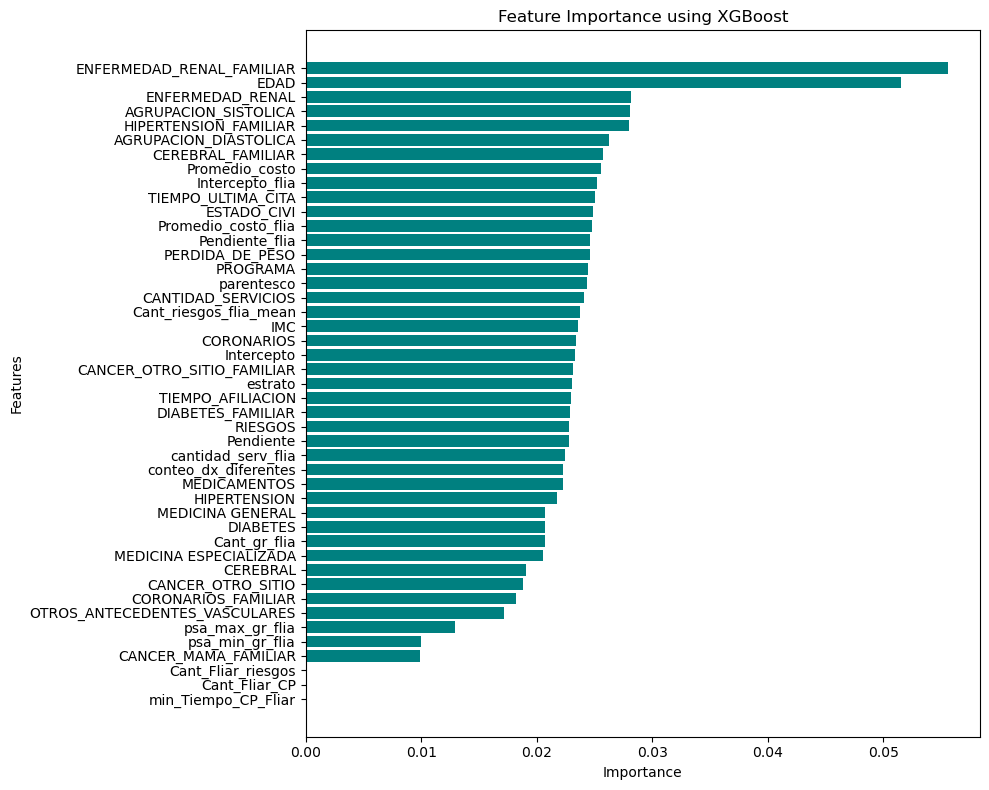

In [6]:
df_encoded = df_train.copy()
for column in ordinal_columns + nominal_columns + ['IMC']:
    df_encoded[column] = df_encoded[column].astype('category')
X = df_encoded.drop(columns=['Target'])
y = df_encoded['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)
model.fit(X_train, y_train)

importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance using XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [7]:
X_train_small = X_train.sample(frac=0.1, random_state=42)
y_train_small = y_train.loc[X_train_small.index] 

In [8]:
features_to_drop = ['Cant_Fliar_riesgos', 'Cant_Fliar_CP', 'min_Tiempo_CP_Fliar', 'psa_min_gr_flia', 'psa_max_gr_flia', 'CANCER_MAMA_FAMILIAR', 'Target']

### Validate dropping features
- In order to be sure whether we decide to drop or not the already identified features, we will run a preliminary model to test with and without the features

In [9]:
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    return f1

# Model 1: With all features
X_all_features = df_encoded.drop(columns=['Target'])
y = df_encoded['Target']

f1_all_features = train_and_evaluate(X_all_features, y)
print(f"F1 Score with all features: {f1_all_features}")

# Model 2: Dropping variables with zero importance
X_reduced_features = df_encoded.drop(columns=['Target'] + features_to_drop)

f1_reduced_features = train_and_evaluate(X_reduced_features, y)
print(f"F1 Score after dropping zero-importance features: {f1_reduced_features}")

F1 Score with all features: 0.5206929740134745
F1 Score after dropping zero-importance features: 0.5384252710985384


After dropping additional features, including `'Cant_Fliar_riesgos'`, `'Cant_Fliar_CP'`, `'min_Tiempo_CP_Fliar'`, `'psa_min_gr_flia'`, `'psa_max_gr_flia'`, and `'CANCER_MAMA_FAMILIAR'`, the model's performance improved. The F1 score increased from **0.5207** (with all features) to **0.5384** (after removing these features), indicating that simplifying the model by excluding both zero-importance features and those with minimal predictive power can enhance the model’s performance. By reducing noise from less significant features, the model was able to generalize better and make more accurate predictions, showcasing the benefits of feature selection in machine learning.

## Preprocessing Pipeline_________________________________________________

In [10]:
updated_numeric_columns = [col for col in numeric_columns if col not in features_to_drop]
updated_ordinal_columns = [col for col in ordinal_columns if col not in features_to_drop]
updated_nominal_columns = [col for col in nominal_columns if col not in features_to_drop]

In [11]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('winsorizer', Winsorizer(capping_method='quantiles', tail='right', fold=0.05)),
    ('scaler', StandardScaler()),
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, updated_numeric_columns),
        ('ord', ordinal_transformer, updated_ordinal_columns),
        ('nom', nominal_transformer, updated_nominal_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('drop_columns', 'passthrough'),
    ('preprocessor', preprocessor)
])

#### Applying preprocessor pipeline
- Imputation and dropping

In [12]:
X = df_train.drop(columns=features_to_drop)
y = df_train['Target']

pipeline.fit(X)
X_train_transformed = pipeline.transform(X)


#### Converting the pipeline output into a readable data frame

In [13]:
transformed_columns = (
    updated_numeric_columns + 
    updated_ordinal_columns + 
    list(pipeline.named_steps['preprocessor'].transformers_[2][1]['onehot'].get_feature_names_out(updated_nominal_columns))
)

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_columns)
X_train_transformed_df

,Cant_gr_flia,Cant_riesgos_flia_mean,cantidad_serv_flia,CANTIDAD_SERVICIOS,conteo_dx_diferentes,EDAD,Pendiente,Pendiente_flia,Promedio_costo,Promedio_costo_flia,...,parentesco_Conyuge,parentesco_Hijo,parentesco_None,parentesco_Otros,parentesco_Padres,parentesco_Sin Descripcion,parentesco_Trabajador,PROGRAMA_PAC,PROGRAMA_POS,PROGRAMA_RS
0,-0.384157,-0.563530,0.401860,0.753479,1.257173,0.182457,0.252586,0.107666,0.054439,-0.462491,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.384157,0.927491,0.010062,0.128135,0.120713,0.182457,0.116429,0.065212,-0.303798,-0.551898,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.384157,-0.563530,0.488926,1.128685,1.257173,1.345805,0.373599,0.552950,3.460334,1.626476,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.384157,-0.563530,-0.033472,-0.497209,0.120713,0.182457,0.052043,0.051036,-0.475511,-0.519583,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.368600,2.418511,-0.773536,-0.247071,0.120713,-0.399217,0.095735,0.063400,-0.524489,-0.568444,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23489,0.600287,-0.563530,-0.120538,-0.747346,-1.015746,0.182457,0.070790,0.115060,-0.504629,-0.353771,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23490,-1.368600,2.418511,-0.599403,-0.122002,0.120713,-1.562564,0.174548,0.064680,-0.331662,-0.561431,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23491,-1.368600,-0.563530,-0.425270,0.378272,1.257173,-0.399217,0.103409,0.077918,-0.263069,-0.484856,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23492,-1.368600,-0.563530,-0.904135,-0.747346,-0.447517,0.473294,0.056937,0.063510,-0.613168,-0.567838,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<span style="color:red">Revisar el conteo de valores atipicos !!!!!!!!!!!!!</span>

In [14]:
def calculate_iqr(df, numeric_columns):
    """
    This function takes a dataframe and returns a dataframe that contains 
    the Interquartile Range (IQR) for each numeric column in the dataframe.
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    
    Returns:
    pd.DataFrame: Dataframe containing IQR values for each numeric column
    """
    # Select numeric columns from the dataframe
    df_numeric_columns = df[numeric_columns]
    
    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for each numeric column
    Q1 = df_numeric_columns.quantile(0.25)
    Q3 = df_numeric_columns.quantile(0.75)
    
    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Create a dataframe to store the IQR values
    iqr_df = pd.DataFrame({
        'Column': IQR.index,
        'IQR': IQR.values
    }).sort_values(by='IQR', ascending=False)
    
    return iqr_df


In [15]:
iqr_result = calculate_iqr(df_train, numeric_columns)
iqr_result

,Column,IQR
11,Promedio_costo_flia,236650.583333
10,Promedio_costo,146698.083333
21,Intercepto_flia,104989.850000
20,Intercepto,92525.866667
8,Pendiente,19009.150000
9,Pendiente_flia,16466.421429
17,TIEMPO_AFILIACION,206.000000
2,cantidad_serv_flia,29.000000
3,CANTIDAD_SERVICIOS,9.000000
5,EDAD,6.000000


In [16]:
iqr_result_after = calculate_iqr(X_train_transformed_df, updated_numeric_columns)
print(iqr_result_after)

                    Column       IQR
13       TIEMPO_AFILIACION  1.987884
12        MEDICINA GENERAL  1.805631
5                     EDAD  1.745021
4     conteo_dx_diferentes  1.704689
2       cantidad_serv_flia  1.262462
3       CANTIDAD_SERVICIOS  1.125619
1   Cant_riesgos_flia_mean  0.994014
0             Cant_gr_flia  0.984443
10            MEDICAMENTOS  0.896945
14      TIEMPO_ULTIMA_CITA  0.693520
11  MEDICINA ESPECIALIZADA  0.592071
8           Promedio_costo  0.576878
9      Promedio_costo_flia  0.512262
16              Intercepto  0.139274
17         Intercepto_flia  0.126111
6                Pendiente  0.066786
7           Pendiente_flia  0.045561
15         PERDIDA_DE_PESO  0.000000


### PCA .....

## Bayesian Optimization

In [17]:
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction


In [18]:
# X_train = X_train_small
# y_train = y_train_small

# Again but with accuracy

In [19]:
# # Updated preprocessing pipeline
# # Make sure you have the correct categorization of columns: numeric, ordinal, and nominal



# # Numeric columns: Winsorizing and scaling
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('winsorizer', Winsorizer(capping_method='quantiles', tail='right', fold=0.05)),
#     ('scaler', StandardScaler()),
# ])

# # Ordinal columns: Impute and encode
# ordinal_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
# ])

# # Nominal columns: Impute and one-hot encode
# nominal_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Added dense output for compatibility
# ])

# # Preprocessor to handle different types of columns
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, updated_numeric_columns),  # Process numeric columns
#         ('ord', ordinal_transformer, updated_ordinal_columns),  # Process ordinal columns
#         ('nom', nominal_transformer, updated_nominal_columns)   # Process nominal columns
#     ]
# )

# # Ensure that the preprocessing pipeline is used before PCA in your pipeline
# n_components_pca = 10  # Adjust based on your dataset

# # Define the SVM evaluation function using accuracy as the metric
# def svm_evaluate(C, gamma, kernel_choice):
#     kernel = 'linear' if kernel_choice < 0.5 else 'rbf'
    
#     # Create a complete pipeline: Preprocessing + PCA + SVM
#     model_pipeline = Pipeline([
#         ('preprocessor', preprocessor),  # Include the preprocessing pipeline
#         ('pca', PCA(n_components=n_components_pca, random_state=42)),  # Add PCA after preprocessing
#         ('svm', SVC(C=C, gamma=gamma, kernel=kernel, probability=True))  # SVM with hyperparameters
#     ])
    
#     # Perform K-fold cross-validation and return mean accuracy score
#     accuracy_scores = cross_val_score(model_pipeline, X_train, y_train, cv=3, scoring='accuracy', verbose=0)
    
#     return accuracy_scores.mean()

# # Define the parameter bounds for Bayesian Optimization
# pbounds = {
#     'C': (0.1, 10),        # Regularization parameter
#     'gamma': (0.5, 2),     # Kernel coefficient for 'rbf'
#     'kernel_choice': (0, 1)  # 0 for 'linear', 1 for 'rbf'
# }

# # Set up the Bayesian optimizer
# optimizer = BayesianOptimization(
#     f=svm_evaluate,
#     pbounds=pbounds,
#     random_state=42,
#     verbose=2
# )

# # Run the optimization without the progress bar
# optimizer.maximize(init_points=5, n_iter=10)

# # Output the best parameters
# best_params = optimizer.max
# print("Best parameters found:", best_params)

# # Train the final SVM model with the best parameters
# C_opt = best_params['params']['C']
# gamma_opt = best_params['params']['gamma']
# kernel_opt = 'linear' if best_params['params']['kernel_choice'] < 0.5 else 'rbf'

# # Final pipeline with best hyperparameters
# best_svm_model = Pipeline([
#     ('preprocessor', preprocessor),  # Include the preprocessing pipeline
#     ('pca', PCA(n_components=n_components_pca, random_state=42)),  # Add PCA
#     ('svm', SVC(C=C_opt, gamma=gamma_opt, kernel=kernel_opt, probability=True))  # Best SVM model
# ])

# # Train the best model using the entire training dataset
# best_svm_model.fit(X_train, y_train)

# # Evaluate the model on the test set
# y_pred_test_proba = best_svm_model.predict(X_test)

# # Evaluate using accuracy score on the test set
# test_accuracy = accuracy_score(y_test, y_pred_test_proba)

# print(f"Test Accuracy: {test_accuracy:.4f}")


In [20]:
# # Define the preprocessing pipeline components
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('winsorizer', Winsorizer(capping_method='quantiles', tail='right', fold=0.05)),
#     ('scaler', StandardScaler()),
# ])

# ordinal_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
# ])

# nominal_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Added dense output for compatibility
# ])

# # Preprocessor to handle different types of columns
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, updated_numeric_columns),  # Process numeric columns
#         ('ord', ordinal_transformer, updated_ordinal_columns),  # Process ordinal columns
#         ('nom', nominal_transformer, updated_nominal_columns)   # Process nominal columns
#     ]
# )

# # Define the SVM evaluation function using accuracy as the metric and adding PCA components as a hyperparameter
# def svm_evaluate(C, gamma, kernel_choice, pca_components):
#     # Map kernel_choice to the actual kernel
#     kernel_options = ['linear', 'rbf', 'sigmoid']
#     kernel = kernel_options[int(kernel_choice)]
    
#     # Create a complete pipeline: Preprocessing + PCA + SVM
#     model_pipeline = Pipeline([
#         ('preprocessor', preprocessor),  # Include the preprocessing pipeline
#         ('pca', PCA(n_components=int(pca_components), random_state=42)),  # Add PCA with the given number of components
#         ('svm', SVC(C=C, gamma=gamma, kernel=kernel, probability=True))  # SVM with hyperparameters
#     ])
    
#     # Perform K-fold cross-validation and return mean accuracy score
#     accuracy_scores = cross_val_score(model_pipeline, X_train, y_train, cv=3, scoring='accuracy', verbose=0)
    
#     return accuracy_scores.mean()

# # Define the parameter bounds for Bayesian Optimization, including more kernel options and PCA components
# pbounds = {
#     'C': (0.1, 10),        # Regularization parameter
#     'gamma': (0.5, 2),     # Kernel coefficient for 'rbf'
#     'kernel_choice': (0, 2),  # 0 for 'linear', 1 for 'rbf', 2 for 'sigmoid'
#     'pca_components': (2, min(len(X_train.columns), 20))  # PCA components: between 2 and 20 or total features
# }

# # Set up the Bayesian optimizer
# optimizer = BayesianOptimization(
#     f=svm_evaluate,
#     pbounds=pbounds,
#     random_state=42,
#     verbose=2
# )

# # Run the optimization without the progress bar
# optimizer.maximize(init_points=5, n_iter=10)

# # Output the best parameters
# best_params = optimizer.max
# print("Best parameters found:", best_params)

# # Train the final SVM model with the best parameters
# C_opt = best_params['params']['C']
# gamma_opt = best_params['params']['gamma']
# kernel_opt = ['linear', 'rbf', 'poly', 'sigmoid'][int(best_params['params']['kernel_choice'])]
# pca_opt = int(best_params['params']['pca_components'])

# # Final pipeline with best hyperparameters
# best_svm_model = Pipeline([
#     ('preprocessor', preprocessor),  # Include the preprocessing pipeline
#     ('pca', PCA(n_components=pca_opt, random_state=42)),  # Add PCA with optimal components
#     ('svm', SVC(C=C_opt, gamma=gamma_opt, kernel=kernel_opt, probability=True))  # Best SVM model
# ])

# # Train the best model using the entire training dataset
# best_svm_model.fit(X_train, y_train)

# # Evaluate the model on the test set
# y_pred_test = best_svm_model.predict(X_test)

# # Evaluate using accuracy score on the test set
# test_accuracy = accuracy_score(y_test, y_pred_test)

# print(f"Test Accuracy: {test_accuracy:.4f}")

In [21]:
# {'target': 0.8786975952330283,
#  'params': {'SVC_C': 0.062287868101808655,
#   'SVC_gamma': 1.8575512621107662,
#   'imputer_strategy': 0.5593641233259324,
#   'kernel_choice': 0.6128341180464585,
#   'knn_imputer_k': 8.00741215202442,
#   'pca_components': 2.21106695791746,
#   'pca_strategy': 0.28651352093336346}}

SVM Accuracy (CV 5-fold): 0.7122
Random Forest Accuracy (CV 5-fold): 0.7223
Logistic Regression Accuracy (CV 5-fold): 0.7069

Best model: Random Forest with cross-validated accuracy: 0.7223
Predictions on the test set:
[0 0 0 ... 0 1 0]

Best model Random Forest saved as 'best_model_pipeline.pkl'


In [22]:

# # Step 1: Best hyperparameters obtained from Bayesian Optimization
# C_opt = 0.062287868
# gamma_opt = 1.8575512621107
# kernel_opt = 'linear'  # kernel_choice of 1.0 corresponds to 'rbf'

# # Step 2: Recreate the pipeline with the best hyperparameters
# best_svm_model = Pipeline([
#     ('preprocessor', preprocessor),  # Include the preprocessing pipeline
#     # ('pca', PCA(n_components=10, random_state=42)),  # Using n_components as defined earlier
#     ('svm', SVC(C=C_opt, gamma=gamma_opt, kernel=kernel_opt, probability=True))  # Best SVM model with 'rbf' kernel
# ])

# # Step 3: Fit the model on the full training data
# best_svm_model.fit(X_train, y_train)

# # Step 4: Transform the test data using the same preprocessor
# X_test_transformed = best_svm_model.named_steps['preprocessor'].transform(df_test)

# # Step 5: Make predictions on the df_test data
# y_test_predictions = best_svm_model.predict(df_test)

# # Step 6: Output the predictions
# print("Predictions on the test set:")
# print(y_test_predictions)

Predictions on the test set:
[0 0 0 ... 0 0 0]


# NN Working

In [23]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from scikeras.wrappers import KerasClassifier
# from sklearn.model_selection import cross_val_score
# from tensorflow.keras.optimizers import RMSprop, Adam
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
# from sklearn.impute import SimpleImputer
# from bayes_opt import BayesianOptimization
# from feature_engine.outliers import Winsorizer

In [24]:
# # Define the preprocessing pipeline components
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('winsorizer', Winsorizer(capping_method='quantiles', tail='right', fold=0.05)),
#     ('scaler', StandardScaler()),
# ])

# ordinal_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
# ])

# nominal_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
# ])

# # Preprocessor to handle different types of columns
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, updated_numeric_columns),
#         ('ord', ordinal_transformer, updated_ordinal_columns),
#         ('nom', nominal_transformer, updated_nominal_columns)
#     ]
# )

# # Define the neural network with neurons as a parameter
# def create_neural_network(input_dim, learning_rate=0.001, dropout_rate=0.2, neurons=32, neurons_2=16):
#     model = Sequential()
#     model.add(Dense(neurons, input_dim=input_dim, activation='relu'))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(neurons_2, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
    
#     optimizer = RMSprop(learning_rate=learning_rate)
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
#     return model

# # Wrap the Keras model with KerasClassifier and add neurons as a parameter
# def nn_evaluate(learning_rate, epochs, batch_size, neurons, neurons_2, dropout_rate):
#     # Get feature dimensions after preprocessing
#     preprocessor.fit(X_train)  # Ensure preprocessing pipeline is fitted
#     X_train_transformed = preprocessor.transform(X_train)
    
#     input_dim = X_train_transformed.shape[1]  # Input dimension after preprocessing
    
#     model_pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ('nn', KerasClassifier(build_fn=lambda: create_neural_network(input_dim, 
#                                                                       learning_rate=learning_rate, 
#                                                                       neurons=int(neurons), 
#                                                                       neurons_2=int(neurons_2), 
#                                                                       dropout_rate=dropout_rate), 
#                                epochs=int(epochs), 
#                                batch_size=int(batch_size),
#                                verbose=0))  # Silent training
#     ])
    
#     # Perform K-fold cross-validation and return mean ROC AUC score
#     roc_auc_scores = cross_val_score(model_pipeline, X_train, y_train, cv=3, scoring='roc_auc', verbose=0)
#     return roc_auc_scores.mean()

# # Define the parameter bounds for Bayesian Optimization including neurons and dropout_rate
# pbounds = {
#     'learning_rate': (0.00001, 1),   # Learning rate for the neural network
#     'epochs': (10, 200),             # Number of epochs to train
#     'batch_size': (32, 256),         # Batch size
#     'neurons': (16, 256),            # Number of neurons in the first layer
#     'neurons_2': (8, 128),           # Number of neurons in the second layer
#     'dropout_rate': (0.1, 0.5)       # Dropout rate for regularization
# }

# # Set up the Bayesian optimizer
# optimizer = BayesianOptimization(
#     f=nn_evaluate,
#     pbounds=pbounds,
#     random_state=42,
#     verbose=2
# )

# # Run the optimization
# optimizer.maximize(init_points=10, n_iter=40)  # Increase n_iter for more exploration

# # Output the best parameters
# best_params = optimizer.max
# print("Best parameters found:", best_params)

In [25]:
# # Train the final neural network model with the best parameters
# learning_rate_opt = best_params['params']['learning_rate']
# epochs_opt = int(best_params['params']['epochs'])
# batch_size_opt = int(best_params['params']['batch_size'])
# pca_opt = int(best_params['params']['pca_components'])

# # Final pipeline with best hyperparameters
# best_nn_model = Pipeline([
#     ('preprocessor', preprocessor),
#     ('pca', PCA(n_components=pca_opt, random_state=42)),
#     ('nn', KerasClassifier(build_fn=lambda: create_small_neural_network(pca_opt, learning_rate_opt), 
#                            epochs=epochs_opt, 
#                            batch_size=batch_size_opt, 
#                            verbose=0))  # Best NN model
# ])

# # Train the best model using the entire training dataset
# best_nn_model.fit(X_train, y_train)

# # Evaluate the model on the test set
# y_pred_test = best_nn_model.predict(X_test)

# # Evaluate using accuracy score on the test set
# test_accuracy = accuracy_score(y_test, y_pred_test)

# print(f"Test Accuracy: {test_accuracy:.4f}")

Usar diferentes kernel

In [26]:
# len(y_test_predictions)

In [27]:
# df_test

In [32]:
# final_df = pd.DataFrame({
#     'ID': df_test.index,
# 	'Target': y_test_predictions
# })
# final_df

,ID,Target
0,12596,0
1,29326,0
2,24338,0
3,11167,0
4,22074,0
...,...,...
10064,6392,0
10065,5998,0
10066,12654,0
10067,14838,1


In [33]:
# # to csv
# final_df.to_csv('data/preditions_10.csv', index=False)

In [34]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
import joblib

# Step 1: Define the preprocessor with SimpleImputer and KNNImputer based on parameters
# Bayesian optimization parameter determined that 0.559 corresponds to SimpleImputer

if 0.5593641233259324 >= 0.5:
    imputer = SimpleImputer(strategy='mean')
else:
    imputer = KNNImputer(n_neighbors=int(8.00741215202442))

# Best preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', imputer),
    ('scaler', StandardScaler())
])

# Define the preprocessing step based on PCA components from Bayesian optimization
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, updated_numeric_columns)
    ]
)

# Bayesian optimization parameters for SVM
C_opt = 0.062287868101808655
gamma_opt = 1.8575512621107662
kernel_opt = 'linear' if 0.6128341180464585 >= 0.5 else 'rbf'  # kernel_choice of 0.612 means linear
pca_components_opt = int(2.21106695791746)  # PCA components from Bayesian optimization

# Step 2: Define the SVM pipeline with the best hyperparameters
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=pca_components_opt, random_state=42)),
    ('svm', SVC(C=C_opt, gamma=gamma_opt, kernel=kernel_opt, probability=True))
])

# Step 3: Define the Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

# Step 4: K-Fold cross-validation for both models
n_folds = 5

# SVM cross-validation
svm_cv_scores = cross_val_score(svm_pipeline, X_train, y_train, cv=n_folds, scoring='accuracy')
svm_mean_cv_score = np.mean(svm_cv_scores)

# Random Forest cross-validation
rf_cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=n_folds, scoring='accuracy')
rf_mean_cv_score = np.mean(rf_cv_scores)

print(f"SVM Cross-Validated Accuracy: {svm_mean_cv_score:.4f}")
print(f"Random Forest Cross-Validated Accuracy: {rf_mean_cv_score:.4f}")

# Step 5: Select the best model
if svm_mean_cv_score > rf_mean_cv_score:
    print("SVM is the best model")
    best_model_pipeline = svm_pipeline
    best_model_name = "SVM"
else:
    print("Random Forest is the best model")
    best_model_pipeline = rf_pipeline
    best_model_name = "Random Forest"

# Step 6: Train the best model on the full training data
best_model_pipeline.fit(X_train, y_train)

# Step 7: Transform the test data and make predictions
y_test_predictions = best_model_pipeline.predict(df_test)

# Step 8: Ensure the predictions match the order of user ID in the test set
final_df = pd.DataFrame({
    'ID': df_test.index,  # Assuming the index contains the user IDs
    'Target': y_test_predictions
})

# Save submission CSV
submission_file = 'submission.csv'
final_df.to_csv(submission_file, index=False)
print(f"Submission file {submission_file} created successfully.")

# Step 9: Submit to Kaggle
# This assumes that you are running this code in a Kaggle notebook or a local environment with Kaggle CLI installed.
import os
os.system(f'kaggle competitions submit -c fa-ii-2024-ii-flujos-de-modelos-tradicionales -f {submission_file} -m "Best model {best_model_name}"')

# Step 10: Optionally save the best model for later use
joblib.dump(best_model_pipeline, 'best_model_pipeline.pkl')
print(f"Best model saved as 'best_model_pipeline.pkl'.")


SVM Cross-Validated Accuracy: 0.7122
Random Forest Cross-Validated Accuracy: 0.7234
Random Forest is the best model
Submission file submission.csv created successfully.
Best model saved as 'best_model_pipeline.pkl'.


sh: kaggle: command not found
